## Advanced cancer networks and data

## Yihang Xin, Kozo Nishida and Alex Pico

## 2022-05-15

**py4cytoscape 1.3.0**

This notebook will demonstrate network retrieval from the STRING database, basic analysis, loading and visualization TCGA data in Cytoscape from Python using the py4cytoscape package. Relevant subnetworks will be identified using different strategies, including network connectivity.

At the end of this notebook, you will have will be a visualization of TCGA data on a subnetwork built around highly mutated genes in the relevant cancer type.

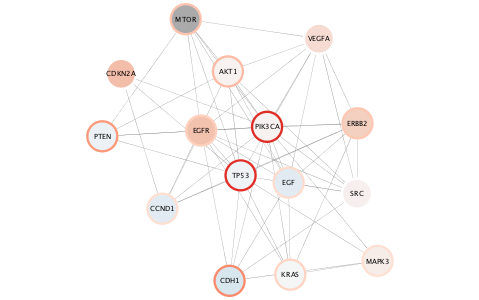

## Prerequisites
There are two options for using py4cytoscape.

1. **LOCAL** Cytoscape (3.9.1 or greater) + **Local** Jupyter environment (including py4cytoscape).
2. **LOCAL** Cytoscape (3.9.1 or greater) + **Remote** Jupyter environment (including py4cytoscape).

### Setup required for option **1.**

- Install Cytoscape on your PC. (See https://cytoscape.org/download.html)
- Install Jupyter on your PC. (See https://jupyter.org/install)
- Install py4cytoscape with `pip install py4cytoscape` on your PC.

### Setup required for option **2.**

- Install Cytoscape on your PC. (See https://cytoscape.org/download.html)
- Run the next cell.
  The next cell installs py4cytoscape in the **REMOTE** Jupyter environment and set up [Jupyter-Bridge](https://github.com/cytoscape/jupyter-bridge).
  (If you use your **LOCAL** Jupyter environment in **your desktop machine** same with Cytoscape, you can **skip** the next cell.)

In [1]:
import requests
exec(requests.get("https://raw.githubusercontent.com/cytoscape/jupyter-bridge/master/client/p4c_init.py").text)
IPython.display.Javascript(_PY4CYTOSCAPE_BROWSER_CLIENT_JS) # Start browser client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

Requirement already satisfied: py4cytoscape in /usr/local/lib/python3.10/dist-packages (1.7.0)

Requirement already satisfied: pandas in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (1.5.3)

Requirement already satisfied: networkx in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (3.1)

Requirement already satisfied: requests in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (2.27.1)

Requirement already satisfied: python-igraph in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (0.10.4)

Requirement already satisfied: colorbrewer in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (0.2.0)

Requirement already satisfied: chardet in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (4.0.0)

Requirement already satisfied: decorator in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (4.4.2)

Requirement already satisfied: backoff in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (2.2.1)

Requirement already satisfied: colour in /usr/local/lib/python3.10/dist-packages (from py4cytoscape) (0.1.5)

Requirement already satisfied: six in /usr/local/lib/python3.10/dist-packages (from colorbrewer->py4cytoscape) (1.16.0)

Requirement already satisfied: python-dateutil>=2.8.1 in /usr/local/lib/python3.10/dist-packages (from pandas->py4cytoscape) (2.8.2)

Requirement already satisfied: pytz>=2020.1 in /usr/local/lib/python3.10/dist-packages (from pandas->py4cytoscape) (2022.7.1)

Requirement already satisfied: numpy>=1.21.0 in /usr/local/lib/python3.10/dist-packages (from pandas->py4cytoscape) (1.22.4)

Requirement already satisfied: igraph==0.10.4 in /usr/local/lib/python3.10/dist-packages (from python-igraph->py4cytoscape) (0.10.4)

Requirement already satisfied: texttable>=1.6.2 in /usr/local/lib/python3.10/dist-packages (from igraph==0.10.4->python-igraph->py4cytoscape) (1.6.7)

Requirement already satisfied: urllib3<1.27,>=1.21.1 in /usr/local/lib/python3.10/dist-packages (from requests->py4cytoscape) (1.26.15)

Requirement already satisfied: certifi>=2017.4.17 in /usr/local/lib/python3.10/dist-packages (from requests->py4cytoscape) (2022.12.7)

Requirement already satisfied: charset-normalizer~=2.0.0 in /usr/local/lib/python3.10/dist-packages (from requests->py4cytoscape) (2.0.12)

Requirement already satisfied: idna<4,>=2.5 in /usr/local/lib/python3.10/dist-packages (from requests->py4cytoscape) (3.4)

NumExpr defaulting to 2 threads.

Loading Javascript client ... 3e0cf5ad-aa68-4853-83c1-21fd09298b06 on https://jupyter-bridge.cytoscape.org
ADVICE: WHEN RUNNING UNDER COLAB, DO NOT RE-RUN THIS CELL WITHOUT MANUALLY EXECUTING Runtime | Factory Reset Runtime FROM THE COLAB MENU FIRST.


<IPython.core.display.Javascript object>

## Import the required packages


In [2]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import sys
from time import sleep
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import py4cytoscape as p4c
from IPython.display import Image
%matplotlib inline
pd.options.mode.chained_assignment = None

## Setup Cytoscape
* Launch Cytoscape on your local machine. If you haven't already installed Cytoscape, then download the latest version from http://cytoscape.org.
* Install the STRING app, if you haven't already: http://apps.cytoscape.org/apps/stringapp
* Install the filetransfer app from https://apps.cytoscape.org/apps/filetransfer
* Leave Cytoscape running in the background during the remainder of the tutorial.
* Check cytoscape connection.

You can also install app inside Python notebook by running "py4cytoscape.install_app('Your App')"

In [4]:
p4c.cytoscape_version_info()

{'apiVersion': 'v1',
 'cytoscapeVersion': '3.9.1',
 'automationAPIVersion': '1.7.0',
 'py4cytoscapeVersion': '1.7.0',
 'jupyterBridgeVersion': '0.0.2'}

## Step 1: Getting Disease Networks

Use Cytoscape to query the STRING database for networks of genes associated with breast cancer and ovarian cancer.

### Query STRING database by disease to generate networks

#### Breast cancer

In [5]:
string_cmd_list = ['string disease query','disease="breast cancer"', 'species="Homo sapiens"', 'limit=150', 'cutoff=0.9']

In [6]:
string_cmd = " ".join(string_cmd_list)

In [7]:
p4c.commands.commands_run(string_cmd)

["Loaded network 'STRING network - breast cancer' with 150 nodes and 847 edges"]

#### Ovarian cancer


In [8]:
string_cmd_list = ['string disease query','disease="ovarian cancer"', 'species="Homo sapiens"', 'limit=150', 'cutoff=0.9']

In [9]:
string_cmd = " ".join(string_cmd_list)

In [10]:
p4c.commands.commands_run(string_cmd)

["Loaded network 'STRING network - ovarian cancer' with 150 nodes and 749 edges"]

## Step 2: Interacting with Cytoscape 

### Get list of networks 

In [11]:
network_names = p4c.get_network_list()
network_names

['STRING network - breast cancer', 'STRING network - ovarian cancer']

### Layout network

In [12]:
# You can use either network suid or network name in the argument
p4c.layout_network('circular', 'STRING network - ovarian cancer')

{}

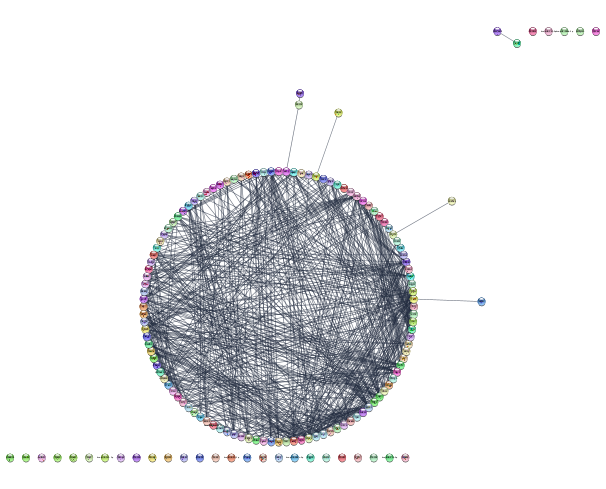

In [13]:
p4c.notebook_export_show_image()

#### List of layout algorithms available

In [14]:
p4c.commands.cyrest_get('apply/layouts')

['attribute-circle',
 'stacked-node-layout',
 'attribute-grid',
 'degree-circle',
 'circular',
 'attributes-layout',
 'kamada-kawai',
 'force-directed',
 'cose',
 'grid',
 'hierarchical',
 'fruchterman-rheingold',
 'isom']

In [15]:
p4c.layout_network('force-directed', 'STRING network - ovarian cancer')

{}

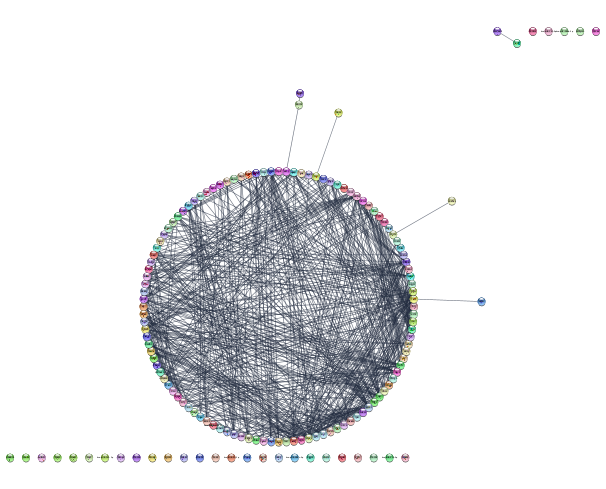

In [16]:
p4c.notebook_export_show_image()

#### Layout with parameters!

In [17]:
p4c.set_layout_properties('force-directed', {'defaultSpringLength': 5, 'defaultSpringCoefficient': .000004})

''

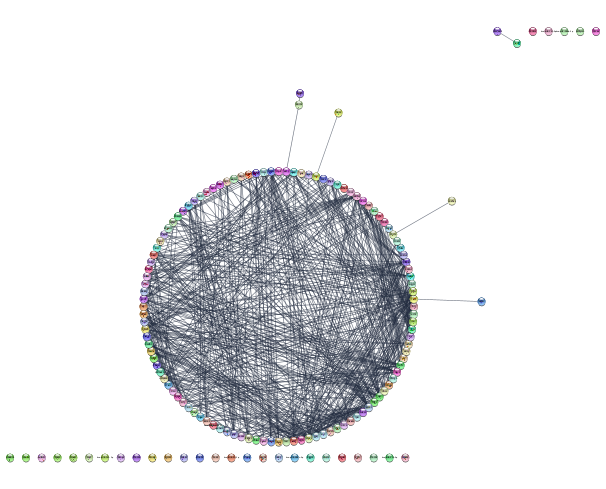

In [18]:
p4c.notebook_export_show_image()

In [19]:
p4c.get_layout_property_names('force-directed')

['numIterations',
 'defaultSpringCoefficient',
 'defaultSpringLength',
 'defaultNodeMass',
 'isDeterministic',
 'singlePartition']

These *command* calls will allow you to interrogate the layouts and parameters available in your active Cytoscape session. This includes any layouts added by apps you've installed!

### Get table data from network
Now, let's look at the tablular data associated with our STRING networks...

In [20]:
p4c.get_table_column_names()

['SUID',
 'shared name',
 'name',
 'selected',
 'stringdb::canonical name',
 'display name',
 'stringdb::full name',
 'stringdb::database identifier',
 'stringdb::description',
 '@id',
 'stringdb::namespace',
 'stringdb::node type',
 'query term',
 'stringdb::sequence',
 'stringdb::species',
 'stringdb::STRING style',
 'stringdb::enhancedLabel Passthrough',
 'compartment::cytoskeleton',
 'compartment::cytosol',
 'compartment::endoplasmic reticulum',
 'compartment::endosome',
 'compartment::extracellular',
 'compartment::golgi apparatus',
 'compartment::lysosome',
 'compartment::mitochondrion',
 'compartment::nucleus',
 'compartment::peroxisome',
 'compartment::plasma membrane',
 'stringdb::structures',
 'target::development level',
 'target::family',
 'tissue::adrenal gland',
 'tissue::blood',
 'tissue::bone',
 'tissue::bone marrow',
 'tissue::eye',
 'tissue::gall bladder',
 'tissue::heart',
 'tissue::intestine',
 'tissue::kidney',
 'tissue::liver',
 'tissue::lung',
 'tissue::muscle',


#### Retrieve disease scores 
We can retrieve any set of columns from Cytoscape and store them as a data frame.

In [21]:
disease_score_table = p4c.get_table_columns(table='node', columns='stringdb::disease score', network='STRING network - ovarian cancer')
disease_score_table.head()

,stringdb::disease score
105985,2.667748
105730,2.797948
105733,5.000000
105988,2.738766
105991,2.737449


Text(0, 0.5, 'frequency')

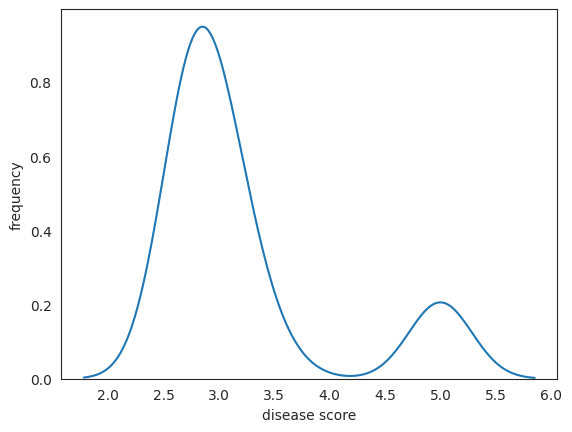

In [22]:
sns.set_style("white")
sns.kdeplot(data=disease_score_table["stringdb::disease score"].astype(float) )
plt.xlabel("disease score")
plt.ylabel("frequency")

### Generate subnetworks
In order to reflect your exploration back onto the network, let's generate subnetworks...

...from top quartile of 'disease score'

In [23]:
top_quart=disease_score_table["stringdb::disease score"].quantile(0.75)
top_nodes=disease_score_table[disease_score_table["stringdb::disease score"]>top_quart].index.tolist()
top_nodes = [str(n) for n in top_nodes]

In [24]:
p4c.create_subnetwork(nodes=top_nodes, subnetwork_name="top disease quartile")

110306

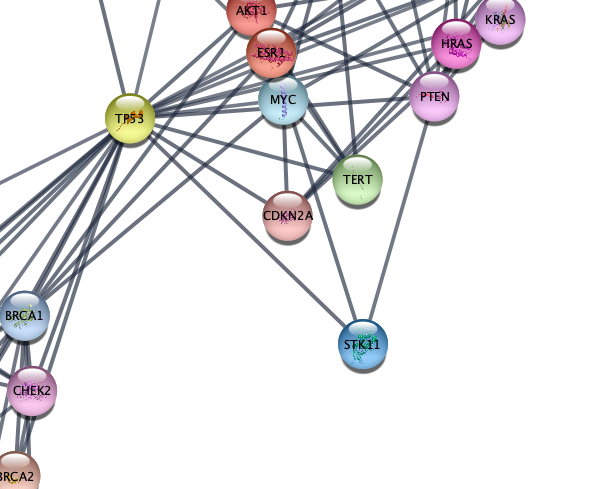

In [25]:
p4c.notebook_export_show_image()

...of connected nodes only

In [26]:
p4c.create_subnetwork(nodes="selected", edges="all", subnetwork_name="top disease quartile connected")

111130

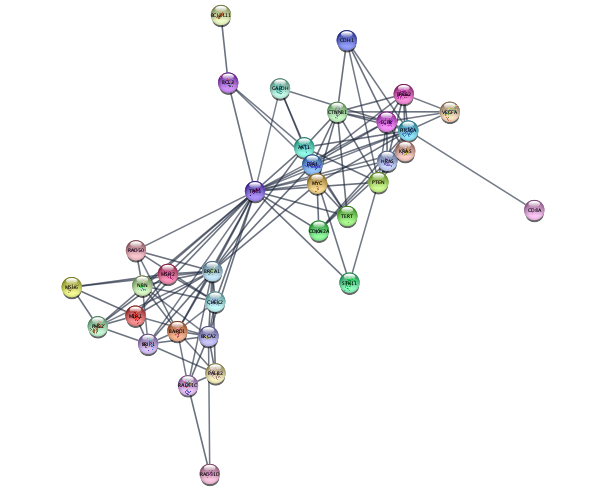

In [27]:
p4c.notebook_export_show_image()

...from first neighbors of top 3 genes, using the network connectivity together with the data to direct discovery.

In [28]:
p4c.set_current_network('STRING network - ovarian cancer')

{}

In [29]:
top_nodes=disease_score_table.sort_values(by=["stringdb::disease score"],\
                                         ascending=False)
top_nodes=top_nodes.index.tolist()[:3]
print(top_nodes)

[105874, 106117, 105835]


In [30]:
top_nodes

[105874, 106117, 105835]

In [31]:
p4c.select_nodes(nodes=top_nodes)

{'nodes': [105874, 106117, 105835], 'edges': []}

In [32]:
p4c.select_first_neighbors()

{'nodes': [105874,
  105841,
  105907,
  105976,
  106039,
  105847,
  105913,
  105694,
  105790,
  106078,
  105886,
  105757,
  105823,
  105919,
  105892,
  106054,
  106117,
  106120,
  106057,
  105865,
  105772,
  105835,
  105739],
 'edges': []}

In [33]:
p4c.create_subnetwork(nodes="selected", subnetwork_name="top disease neighbors")

111781

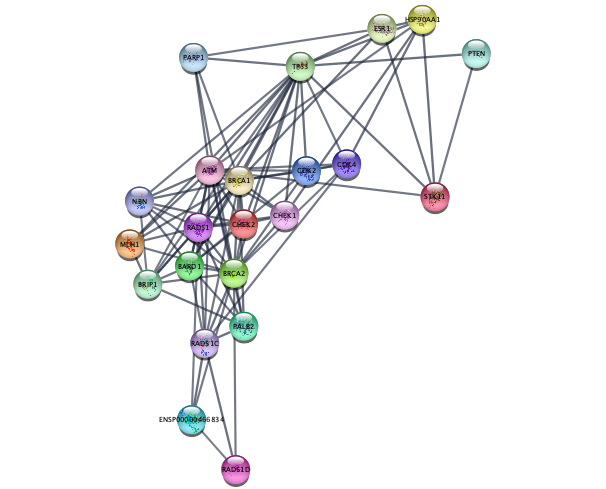

In [34]:
p4c.notebook_export_show_image()

In [35]:
p4c.layout_network('force-directed', 'top disease neighbors')

{}

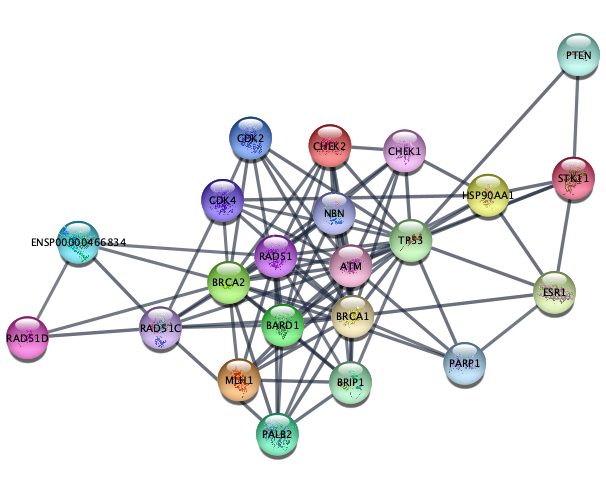

In [36]:
p4c.notebook_export_show_image()

...from diffusion algorithm starting with top 3 genes, using the network connectivity in a more subtle way than just first-degree neighbors.

In [37]:
p4c.set_current_network('STRING network - ovarian cancer')
p4c.select_nodes(nodes=top_nodes)

{'nodes': [105874, 106117, 105835], 'edges': []}

In [38]:
p4c.diffusion_basic()

{'heatColumn': 'diffusion_output_heat', 'rankColumn': 'diffusion_output_rank'}

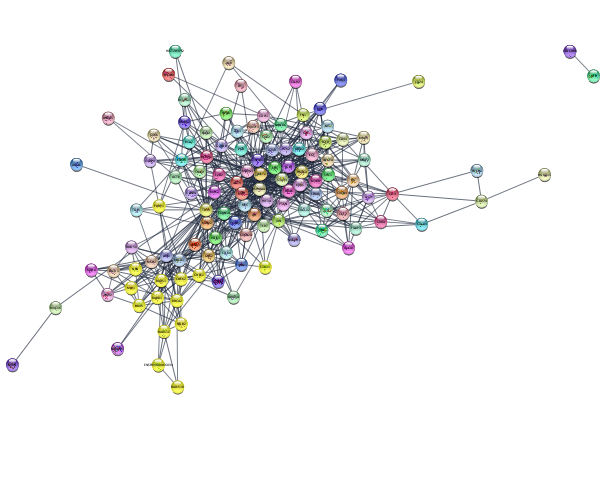

In [39]:
p4c.notebook_export_show_image()

In [40]:
p4c.create_subnetwork(nodes="selected", subnetwork_name="top disease diffusion")

112382

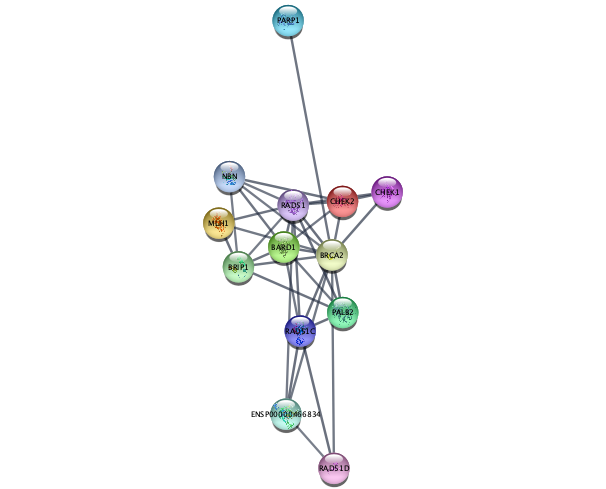

In [41]:
p4c.notebook_export_show_image()

In [42]:
p4c.layout_network('force-directed', 'top disease diffusion')

{}

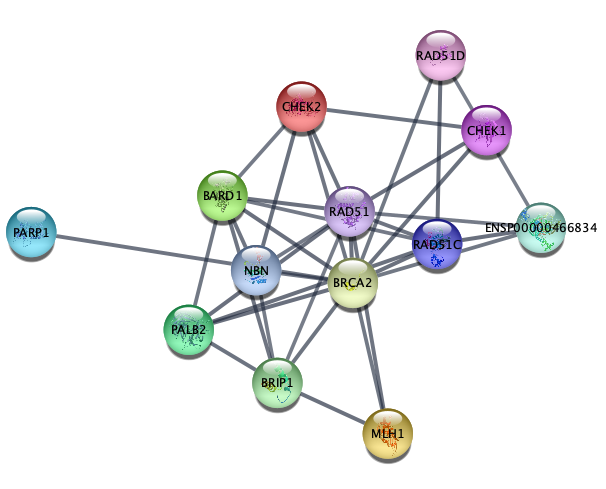

In [43]:
p4c.notebook_export_show_image()

## Step 3: Visualizing data on networks

### Load datasets
Downloaded TCGA data from https://portal.gdc.cancer.gov/. Also available via each TCGA publication, e.g.:
 
* Breast: https://tcga-data.nci.nih.gov/docs/publications/brca_2012/
* Ovarian: https://tcga-data.nci.nih.gov/docs/publications/ov_2011/

Here we download TCGA data from our GitHub repo.

In [44]:
brc_expr=pd.read_table("https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/brc.exp.tsv")
brc_mut=pd.read_table("https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/brc.mut.tsv")

### Breast Cancer Datset
These datasets are similar to the data frames you normarlly encounter in R. For diversity, one using row.names to store corresponding gene names and the other uses the first column. Both are easy to import into Cytoscape.

In [45]:
brc_expr.head()

,expr.mean
ELMO2,-0.000167
CREB3L1,-0.005408
RPS11,0.018381
PNMA1,-0.065037
MMP2,-0.074444


In [46]:
brc_mut.head()

,Hugo_Symbol,mut_count,missense_mut_count
13,A1CF,2,2
14,A2BP1,3,3
15,A2M,3,2
16,A2ML1,4,4
17,A4GALT,1,0


Let's return to the Breast Cancer network...

In [47]:
p4c.set_current_network('STRING network - breast cancer')
p4c.set_layout_properties('force-directed', {'defaultSpringLength': 5, 'defaultSpringCoefficient': .000004})

''

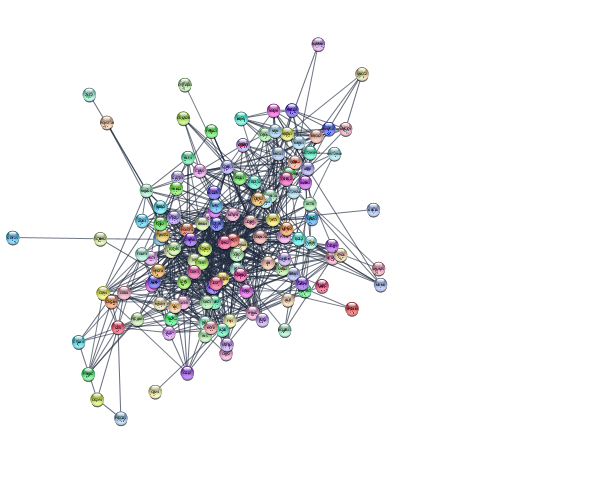

In [48]:
p4c.notebook_export_show_image()

...and use the helper function from py4cytoscape called *load_table_data*


In [49]:
p4c.get_table_column_names()

['SUID',
 'shared name',
 'name',
 'selected',
 'stringdb::canonical name',
 'display name',
 'stringdb::full name',
 'stringdb::database identifier',
 'stringdb::description',
 '@id',
 'stringdb::namespace',
 'stringdb::node type',
 'query term',
 'stringdb::sequence',
 'stringdb::species',
 'stringdb::STRING style',
 'stringdb::enhancedLabel Passthrough',
 'compartment::cytoskeleton',
 'compartment::cytosol',
 'compartment::endoplasmic reticulum',
 'compartment::endosome',
 'compartment::extracellular',
 'compartment::golgi apparatus',
 'compartment::lysosome',
 'compartment::mitochondrion',
 'compartment::nucleus',
 'compartment::peroxisome',
 'compartment::plasma membrane',
 'stringdb::structures',
 'target::development level',
 'target::family',
 'tissue::adrenal gland',
 'tissue::blood',
 'tissue::bone',
 'tissue::bone marrow',
 'tissue::eye',
 'tissue::gall bladder',
 'tissue::heart',
 'tissue::intestine',
 'tissue::kidney',
 'tissue::liver',
 'tissue::lung',
 'tissue::muscle',


In [50]:
p4c.load_table_data(brc_expr, table_key_column='display name')
p4c.load_table_data(brc_mut, data_key_column='Hugo_Symbol', table_key_column='display name')

'Success: Data loaded in defaultnode table'

#### Visual styles
Let's create a new style to visualize our imported data
...starting with the basics, we will specify a few defaults and obvious mappings in a custom style all our own.

In [51]:
defaults = {'NODE_SHAPE': 'ellipse', 'NODE_SIZE': 60, 'NODE_FILL_COLOR':"#AAAAAA", 'EDGE_TRANSPARENCY': 120}
node_labels = p4c.map_visual_property('node label', 'display name', 'p')
p4c.create_visual_style('dataStyle', defaults=defaults, mappings=[node_labels])
p4c.set_visual_style('dataStyle')

{'message': 'Visual Style applied.'}

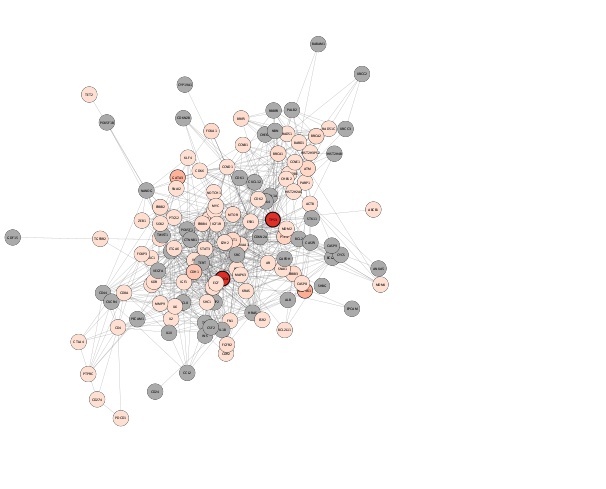

In [52]:
p4c.notebook_export_show_image()

Now let’s update the style with a mapping for mean expression using a standard Color Brewer palette.



In [53]:
p4c.set_node_color_mapping(**p4c.gen_node_color_map('expr.mean', p4c.palette_color_brewer_d_RdBu(), style_name='dataStyle'))

''

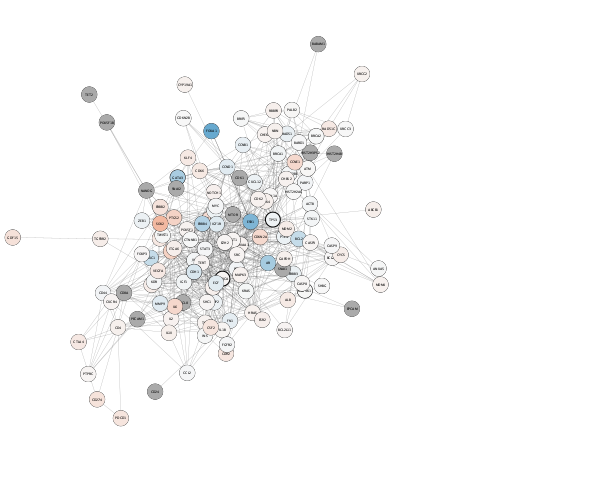

In [54]:
p4c.notebook_export_show_image()

Pro-tip: depending on your data, it may be better to balance your color range over negative and positive values bounded by the largest min or max data value, so that color intensity scales similarly in both directions.

#### Visualize mutation data
OK, now let's update with a mapping for mutation. Here are all the same steps, but this time mapping mutation counts to *both* node border width and color. 

In [55]:
brc_mut_network = p4c.get_table_columns(columns=['mut_count'])

p4c.set_node_color_mapping(**p4c.gen_node_color_map('mut_count', p4c.palette_color_brewer_s_Reds(), style_name='dataStyle'))
p4c.set_node_border_width_mapping('mut_count', table_column_values=[0, 200], widths=[2, 8], style_name='dataStyle')

''

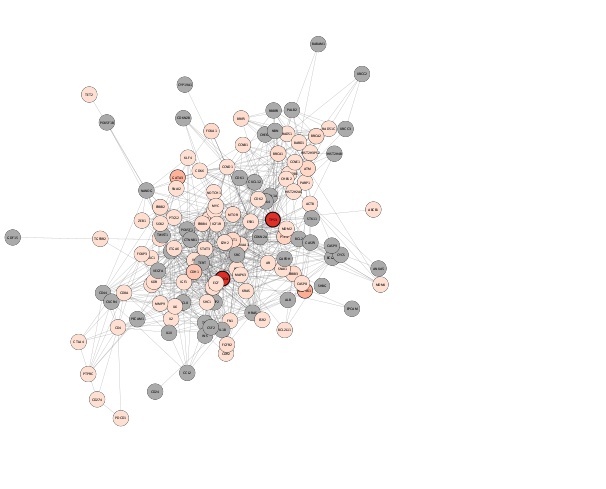

In [56]:
p4c.notebook_export_show_image()

#### Subnetwork based on diffusion from heavily mutated nodes
Now, let's pull in what we learned about subnetwork selection and apply it here...

In [57]:
top_mut=brc_mut_network.dropna().sort_values(by=["mut_count"],ascending=False)
top_mut=top_mut.index.tolist()[:2]

In [58]:
top_mut

[100732, 100726]

In [59]:
p4c.select_nodes(nodes=top_mut)

{'nodes': [100726, 100732], 'edges': []}

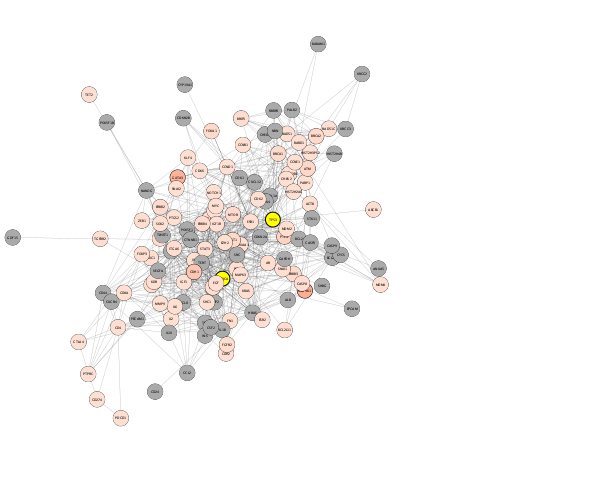

In [60]:
p4c.notebook_export_show_image()

In [61]:
p4c.diffusion_basic()

{'heatColumn': 'diffusion_output_heat', 'rankColumn': 'diffusion_output_rank'}

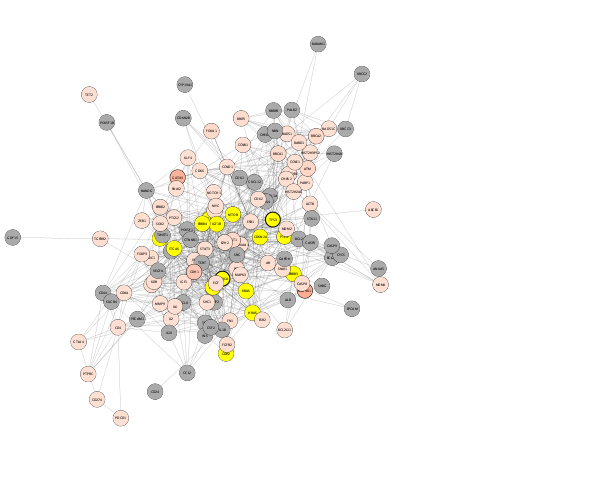

In [62]:
p4c.notebook_export_show_image()

In [63]:
p4c.create_subnetwork(nodes="selected", subnetwork_name="top mutated diffusion")

112746

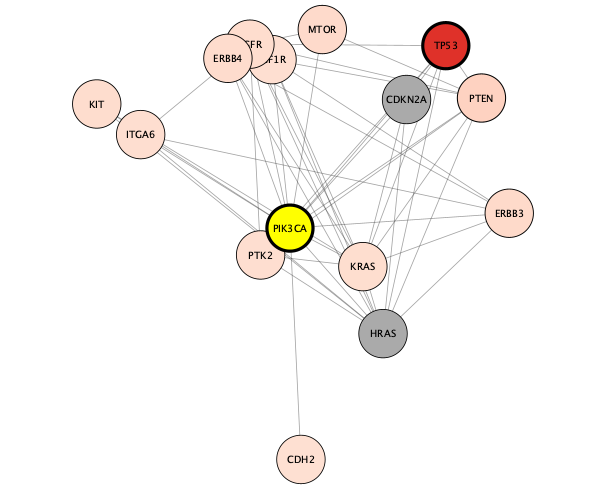

In [64]:
p4c.notebook_export_show_image()

In [65]:
p4c.layout_network('force-directed', 'top disease diffusion')

{}

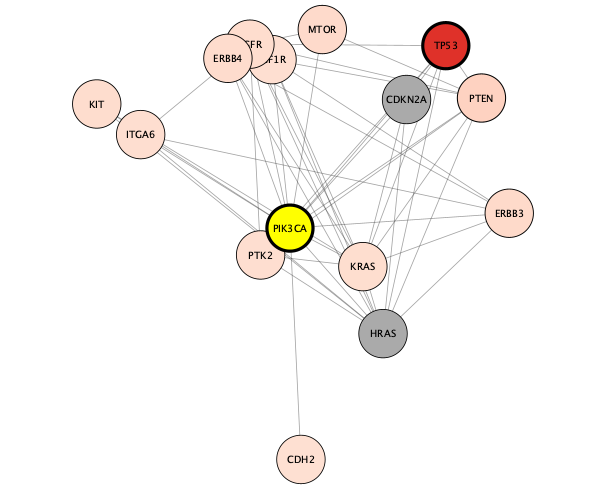

In [66]:
p4c.notebook_export_show_image()

The top mutated genes are based on TCGA data and the diffusion algorithm is operating based on the network connectivity from STRING data, leading to a focused subnetwork view of critical Breast Cancer genes with mean patient expression data mapped to fill color. Now *that's* data integration!

**Pro-tip: You can generate a legend for this in Cytoscape Style tab > Options > Create style... 

### Ovarian Cancer Datset
But what about the other network and datasets? Do we have to repeat *all* of those steps again?  Actually, no!

First, let's switch back over to the Ovarian Cancer network and load our data.

In [67]:
ovc_expr=pd.read_table("https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/ovc.expr.tsv")
ovc_mut=pd.read_table("https://raw.githubusercontent.com/cytoscape/cytoscape-automation/master/for-scripters/Python/data/ovc.mut.tsv")

In [68]:
ovc_expr.head()

,expr.mean
A2BP1,0.001902
A2M,0.022102
A4GALT,-0.033652
A4GNT,-0.006246
AAAS,0.003222


In [69]:
ovc_mut.head()

,Hugo_Symbol,mut_count,missense_mut_count
1,A1CF,1,1
2,A2M,1,1
3,A2ML1,3,2
4,AACS,2,2
5,AADACL4,1,1


In [70]:
p4c.set_current_network("STRING network - ovarian cancer")
p4c.get_table_column_names()

['SUID',
 'shared name',
 'name',
 'selected',
 'stringdb::canonical name',
 'display name',
 'stringdb::full name',
 'stringdb::database identifier',
 'stringdb::description',
 '@id',
 'stringdb::namespace',
 'stringdb::node type',
 'query term',
 'stringdb::sequence',
 'stringdb::species',
 'stringdb::STRING style',
 'stringdb::enhancedLabel Passthrough',
 'compartment::cytoskeleton',
 'compartment::cytosol',
 'compartment::endoplasmic reticulum',
 'compartment::endosome',
 'compartment::extracellular',
 'compartment::golgi apparatus',
 'compartment::lysosome',
 'compartment::mitochondrion',
 'compartment::nucleus',
 'compartment::peroxisome',
 'compartment::plasma membrane',
 'stringdb::structures',
 'target::development level',
 'target::family',
 'tissue::adrenal gland',
 'tissue::blood',
 'tissue::bone',
 'tissue::bone marrow',
 'tissue::eye',
 'tissue::gall bladder',
 'tissue::heart',
 'tissue::intestine',
 'tissue::kidney',
 'tissue::liver',
 'tissue::lung',
 'tissue::muscle',


In [71]:
p4c.load_table_data(ovc_expr, table_key_column='display name')
p4c.load_table_data(ovc_mut, data_key_column='Hugo_Symbol', table_key_column='display name')

'Success: Data loaded in defaultnode table'

**Because we used the same column names in our original data frames, now we can simply apply the *same* visual style created above!**

In [72]:
p4c.set_visual_style('dataStyle')

{'message': 'Visual Style applied.'}

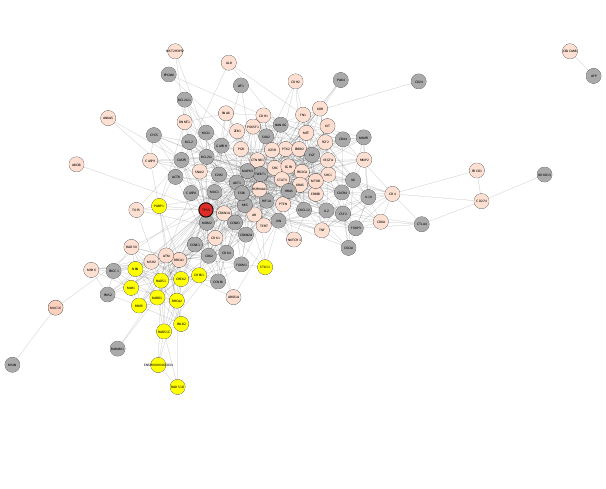

In [73]:
p4c.notebook_export_show_image()

In [74]:
p4c.clear_selection(type='both')

''

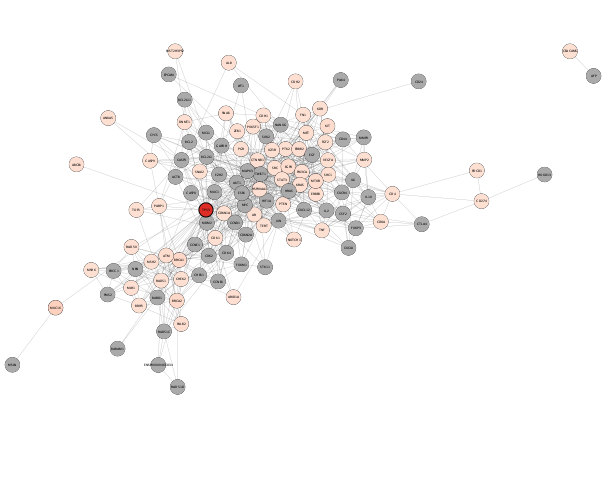

In [75]:
p4c.notebook_export_show_image()

Reusing the same style for both breast and ovarian cancers, we can compare the relative expression and mutation counts across the two datasets. 
For example, notice in the case of ovarian cancer: **decreased** range of mean expression and **fewer** mega-mutated genes.

## Step 4: Saving, sharing and publishing

### Saving a Cytoscape session file
Session files save *everything*. As with most project software, we recommend saving often!

In [76]:
p4c.save_session('cytoscape') # Save current session as cytoscape.cys

{}

### Exporting high resolution image files
You can export extremely high resolution images, including vector graphic formats.

In [77]:
p4c.clear_selection(type='both')
p4c.fit_content()
file_location = p4c.export_image('cytoscape_image', type='PDF')
file_location

{'file': '/Users/yxin/CytoscapeConfiguration/filetransfer/default_sandbox/cytoscape_image.pdf'}

### Exporting interactive web pages via cytoscape.js
You can export the network model in multiple standard formats. And if you want to get really fancy, you can export the model and style in cytoscape.js formats and host interactive views of your network analysis and visualization results online!

In [78]:
p4c.export_network('cytoscape_network','cyjs')
p4c.export_visual_styles('cytoscape_style', type='json') # export the current style in cytoscape.js format

{'file': '/Users/yxin/CytoscapeConfiguration/filetransfer/default_sandbox/cytoscape_style.json'}

More details in Cytoscape manual chapter on [Interactive Web Applications](http://manual.cytoscape.org/en/stable/Export_Your_Data.html#as-an-interactive-web-application-new-in-3-2-0)


And in Cytoscape, you can File>Export as Web Page... to produce a folder of cytoscape.js files and html.


### Additional network analysis and visualization options
* Mapping edge attributes to edge thickness, color and/or transparency (e.g., score or experiments) 
    * EDGE_WIDTH, EDGE_COLOR, EDGE TRANSPARENCY
* Edge bundling
    * bundleEdges()
* Directional edge animation
    * applyStyle('Marquee')
    * updateStyleDefaults(style.name,list('Edge Line Type'='Marquee_Dash'))
* Visualize two or more datasets as split-fill or pie chart, or patient-specific data as radial Circos plot
    * pending support for charts...
* Merge two (or more) networks
    * copyCytoscapeNetwork() or 'network clone'; then addGraphToGraph() (Union only)
    * using igraph: intersection(g1,g2), union(), difference(); followed by toCytoscape() and send2cy()

## swagger
http://localhost:1234/v1/swaggerUI/swagger-ui/index.html?url=http://localhost:1234/v1/commands/swagger.json#/


## Step 5: Wrapping up

You should now know how to...

* Connect to Cytoscape from Python
* Retrieve disease networks from STRING
* Interact with Cytoscape via commands, CyREST, and py4cytoscape
* Load various data types onto networks
* Set visual style defaults and mappings
* Perform selection and create subnetworks
* Save, share and publish your networks
* Find more information on Cytoscape automation

#### Resources
* Growing collection of [cytoscape automation resources](https://github.com/cytoscape/cytoscape-automation/), including **this** tutorial
* Growing collection of [cytoscape tutorial materials](https://github.com/cytoscape/cytoscape-tutorials)
* Active community on [cytoscape-helpdesk](https://groups.google.com/forum/#!forum/cytoscape-helpdesk) for any Cytoscape related questions and suggestions